In [39]:
import pandas as pd
import datetime
from pandas_profiling import ProfileReport
import geopandas as gpd
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder, MeanCategoricalEncoder
from feature_engine import variable_transformers as vt
from feature_engine.outlier_removers import Winsorizer
from shapely.geometry import Point, MultiPolygon, Polygon
import mysql.connector as sql
import details

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [40]:
#Read both dataframes
#Combine the details dataframe with saleshistory dataframe
#details = pd.read_csv('Data/house_data_details_cleaned.csv')
#history = pd.read_csv('Data/house_data_saleshistory_cleaned.csv')

In [41]:
#Upload the saleshistory data to mysql database
db_connection = sql.connect(
    
    host = 'Samuels-MacBook-Air.local',
    user = 'root',
    passwd = details.db_password,
    database = 'realestate_avm'
)


homes = pd.read_sql('SELECT * FROM Homes;', con=db_connection)
history = pd.read_sql('SELECT * FROM SalesHistory;', con=db_connection)

In [42]:
#Lets combine the two dataframes
print(homes.shape, history.shape)
df = pd.merge(homes, history, on='ParcelNumber', how='left')
print(df.shape)

(7937, 18) (15323, 3)
(18170, 20)


In [4]:
#Join the original house dataset with the sales history dataframe
print(gdf.shape, history.shape)
raw_data = pd.merge(gdf, history, on='parcel_number', how='left')
print(raw_data.shape)

#There are some properties in the saleshistory dataframe that are not 
#in the details dataframe. That is why the total number of observations
#do not add up after the merge

(1962, 28) (4824, 3)
(5011, 30)


In [44]:
#We'll be keeping the values from the right dataframe(for columns date and sale_price) since they exist in both dataframes
#There are a lot of null values for properties that are not in the saleshistory. We'll fill those missing values 
#with the values from the left dataframe and then drop the duplicate features from the left dataframe

print(f'Number of missing values for price after the merge and before the imputation: {df.SalePrice_y.isnull().sum()}')
missing = df.loc[df['SalePrice_y'].isnull()].index
df['Date_y'] = df['Date_y'].fillna(df['Date_x'])
df['SalePrice_y'] = df['SalePrice_y'].fillna(df['SalePrice_x'])

df.drop(['Date_x', 'SalePrice_x'], axis=1, inplace=True)
df.rename(columns={'Date_y': 'Date', 'SalePrice_y':'SalePrice'}, inplace=True)

print(f'Number of missing values for price after imputing the missing values: {df.SalePrice.isnull().sum()}')
df.head()

Number of missing values for price after the merge and before the imputation: 2847
Number of missing values for price after imputing the missing values: 0


,ParcelNumber,Address,Latitude,Longitude,HomeSize,LotSize,YearBuilt,Age,SexOffenders,CrimeIndex,EnviornmentalHazards,SchoolQuality,Bedrooms,Bathrooms,Neighborhood,SalePriceTransformed,Date,SalePrice
0,2004006017,8380 Kentland Ave,34.22212,-118.61781,1882.00000,9072.00000,1972,48,4,Very Low,4,Average,4,2,West Hills,923.31900,2020-11-23,850000.00000
1,2004006017,8380 Kentland Ave,34.22212,-118.61781,1882.00000,9072.00000,1972,48,4,Very Low,4,Average,4,2,West Hills,923.31900,2006-11-03,680000.00000
2,2004009012,8356 Sausalito Ave,34.22127,-118.61559,1477.00000,11377.00000,1960,60,5,Very Low,4,Average,3,2,West Hills,882.69400,2020-09-23,777000.00000
3,2004011011,22546 Malden St,34.22459,-118.61834,3422.00000,9972.00000,1973,47,4,Very Low,4,Average,7,5,West Hills,998.66800,2020-10-02,995000.00000
4,2004015018,22711 Michale St,34.22703,-118.62186,2080.00000,11248.00000,1959,61,4,Very Low,5,Average,3,3,West Hills,925.39800,2020-09-28,854000.00000


In [45]:
df = raw_data.copy()
df.describe()

,latitude,longitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,sale_price
count,5011.00000,5011.00000,4728.00000,4933.00000,4773.00000,5011.00000,5011.00000,5011.00000,5011.00000,4622.00000,5011.00000,5011.00000,5011.00000,4575.00000,4575.00000,4902.00000
mean,34.12034,-118.27438,42214.17153,3218648.97223,1963.65326,4930642360.99302,1114278344.59629,1.96188,437413.30273,908449.56729,8.46358,7.61285,1.19677,3.55825,2.78842,1130997.83721
std,0.22390,0.20930,567010.94374,11125001.66065,26.65488,2090258605.64994,47419.56972,1.06923,263877.32929,553740.79956,15.03774,7.45112,0.42478,3.34590,2.98938,4524259.85301
min,33.71913,-118.89380,280.00000,656.00000,1887.00000,93959140.00000,1114172203.00000,1.00000,0.00000,181000.00000,0.00000,1.00000,0.00000,1.00000,1.00000,500.00000
25%,33.98406,-118.42607,1151.00000,5998.00000,1948.00000,3001055065.00000,1114229431.50000,1.00000,199400.00000,538800.00000,1.00000,3.00000,1.00000,2.00000,2.00000,230000.00000
50%,34.08975,-118.29192,1588.50000,7826.00000,1962.00000,5067018001.00000,1114306304.00000,2.00000,406500.00000,740000.00000,4.00000,5.00000,1.00000,3.00000,2.00000,469750.00000
75%,34.19438,-118.14089,2260.75000,21144.00000,1985.00000,6353011035.00000,1114320206.50000,3.00000,602200.00000,1088000.00000,9.50000,9.00000,1.00000,4.00000,3.00000,801125.00000
max,34.78765,-117.65513,14505480.00000,176722920.00000,2020.00000,8765009080.00000,1114349489.00000,7.00000,930301.00000,2950000.00000,136.00000,79.00000,3.00000,56.00000,52.00000,110000000.00000


In [7]:
#Alternatively
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

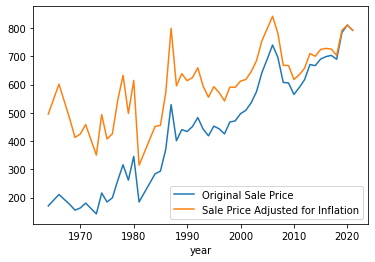

In [22]:
#Below you will see the change in price when adjusting for inflation
fig = plt.figure
real_avg = power_df.groupby('year')['sale_price'].mean().plot(label='Original Sale Price')
adj_avg = power_df.groupby('year')['sale_price_cpi'].mean().plot(label='Sale Price Adjusted for Inflation')
plt.legend()
plt.savefig('Images/sale_price_adjusted.png')

In [23]:
#Determine the age of the property 
power_df['age'] = power_df['date'].dt.year - power_df['year_built']
power_df[['year_built','age']].head()

,year_built,age
0,1955.00000,66.00000
1,1990.00000,31.00000
3,1990.00000,31.00000
4,1958.00000,63.00000
5,1968.00000,53.00000


In [24]:
#Examine the property type feature
temp = pd.concat([power_df.groupby('property_type')['sale_price_cpi'].mean(), power_df.groupby('property_type')['sale_price_cpi'].count(), power_df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price','Count', 'Frequency']
temp['Average sale price'] = temp['Average sale price']**2
temp.sort_values(by=['Count'], axis=0,ascending=False, inplace=True)
temp.dropna(inplace=True)
temp['Count'] = temp['Count'].astype(int)
temp['Average sale price'] = temp['Average sale price'].apply(lambda x: '${:,.2f}'.format(x))
temp['Frequency'] = temp['Frequency'].apply(lambda x: "{0:.2f}%".format(x*100))
print(f'Number of categories for property_type: {power_df.property_type.nunique()}')
temp

Number of categories for property_type: 10


,Average sale price,Count,Frequency
Single Family Residence,"$525,852.94",1974,60.52%
Condominium,"$442,272.17",890,27.28%
"Duplex (2 units, any combination)","$488,839.25",196,6.01%
Planned Unit Development (PUD),"$562,946.88",78,2.39%
Apartment house (5+ units),"$747,508.22",43,1.32%
"Quadplex (4 Units, Any Combination)","$594,118.92",37,1.13%
"Triplex (3 units, any combination)","$532,502.70",33,1.01%
Hotel/Motel,"$965,826.97",5,0.15%
Residential - Vacant Land,"$964,566.66",4,0.12%
MISCELLANEOUS (Commercial),"$420,278.80",2,0.06%


In [1]:
prop_func = lambda x: '${:,.2f}'.format(x)
prop_func(25)

'$25.00'

In [25]:
#Remove every property type except Single Family Residence 
num_1 = power_df.shape[0]
print(f'{num_1} total number of houses')
removed_df = power_df.loc[power_df['property_type']!='Single Family Residence']
num_2 = removed_df.shape[0]
print(f'{num_2} number of houses removed')
power_df = power_df.loc[power_df['property_type']=='Single Family Residence']
print(f'{power_df.shape[0]} number of Single Family Residences remain')

3262 total number of houses
1288 number of houses removed
1974 number of Single Family Residences remain


Lot size upper boundary is 15708.0
Number of observations before removing outliers: 1974
Number of observations after removing outliers: 1855
Removed 119 observations


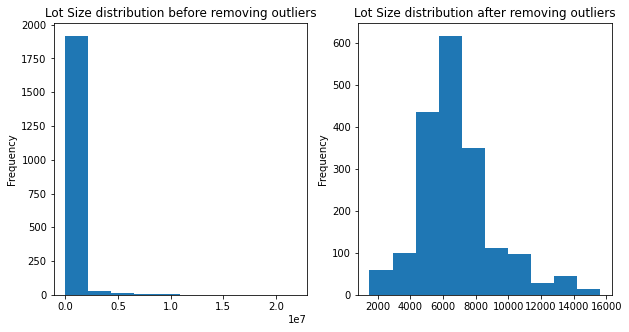

In [26]:
#Remove outliers for lot size
lot_size_upper_boundary, lot_size_lower_boundary = find_skewed_boundaries(power_df, 'lot_size', 3.0)
print(f'Lot size upper boundary is {lot_size_upper_boundary}')

#Remove outlier values
trimmed_df = power_df.loc[power_df['lot_size']<lot_size_upper_boundary,:]
print(f'Number of observations before removing outliers: {power_df.shape[0]}')
print(f'Number of observations after removing outliers: {trimmed_df.shape[0]}')
print(f'Removed {power_df.shape[0]-trimmed_df.shape[0]} observations')

fig, ax = plt.subplots(1,2, figsize=(10,5))

power_df['lot_size'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Lot Size distribution before removing outliers')

trimmed_df['lot_size'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Lot Size distribution after removing outliers')
plt.show()

In [27]:
#Cap the outliers for sex offenders and enviornmental hazards features
windsoriser = Winsorizer(distribution='skewed',
                          tail='right', 
                          fold=1.5,
                          variables=['sex_offenders','enviornmental_hazards'])

windsoriser.fit(trimmed_df)

trimmed_df = windsoriser.transform(trimmed_df)

In [28]:
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['crime_index', 'school_quality'])

ohe_encoder.fit(trimmed_df)

temp = ohe_encoder.transform(trimmed_df)

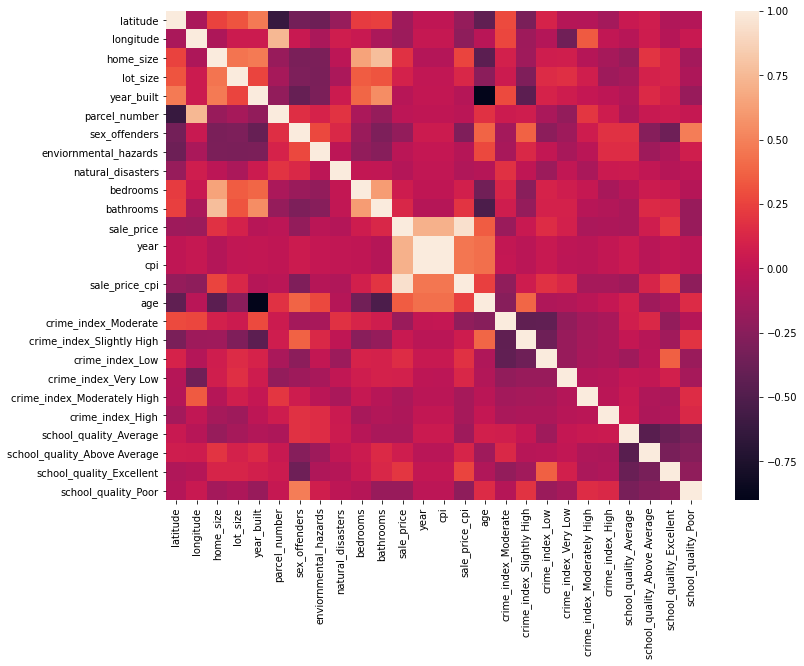

In [29]:
corrmat = temp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

In [30]:
#Identify groups of correlated features
corrmat = trimmed_df.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,cpi,year,0.99866
1,year,cpi,0.99866
2,sale_price_cpi,sale_price,0.94298
3,sale_price,sale_price_cpi,0.94298
4,age,year_built,0.90065
5,year_built,age,0.90065


In [31]:
#Let's examine crime index
temp = pd.concat([trimmed_df.groupby('crime_index')['sale_price_cpi'].mean(), trimmed_df.groupby('crime_index')['sale_price_cpi'].count()], axis=1)
temp.columns = ['Avg Sale Price \'Power Scale\'', 'Count of crime index type']
temp['Avg Sale Price \'Real Scale\''] = (temp['Avg Sale Price \'Power Scale\''])**2
temp.sort_values(by='Avg Sale Price \'Power Scale\'', ascending=False, inplace=True)
temp['Avg Sale Price \'Power Scale\''] = temp['Avg Sale Price \'Power Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp['Avg Sale Price \'Real Scale\''] = temp['Avg Sale Price \'Real Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp

,Avg Sale Price 'Power Scale',Count of crime index type,Avg Sale Price 'Real Scale'
crime_index,,,
Very Low,$806.66,148,"$650,695.10"
Low,$779.88,480,"$608,205.19"
Slightly High,$742.34,500,"$551,064.19"
Moderate,$662.70,623,"$439,176.09"
Moderately High,$604.79,65,"$365,772.71"
High,$564.75,39,"$318,937.38"


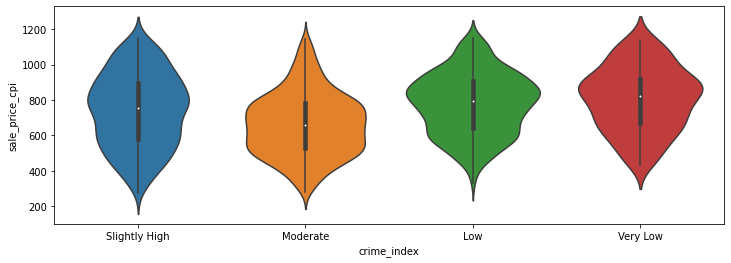

In [32]:
#Box Plot of Crime Index
order=['Slightly High', 'Moderate', 'Low', 'Very Low']
temp = trimmed_df.loc[((trimmed_df['crime_index']!='High') & (trimmed_df['crime_index']!='Moderately High'))]
plt.figure(figsize=(12,4))
sns.violinplot(x='crime_index', y='sale_price_cpi', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [33]:
#Let's examine school quality
temp = pd.concat([trimmed_df.groupby('school_quality')['sale_price_cpi'].mean(), trimmed_df.groupby('school_quality')['sale_price_cpi'].count()], axis=1)
temp.columns = ['Average Sale Price Power Scale', 'Count of school_quality types']
#temp['Average Sale Price Real Scale'] = temp['Average Sale Price Power Scale']
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Power Scale']**2
temp.sort_values(by='Average Sale Price Power Scale', ascending=False, inplace=True)
temp['Average Sale Price Power Scale'] = temp['Average Sale Price Power Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Real Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp

,Average Sale Price Power Scale,Count of school_quality types,Average Sale Price Real Scale
school_quality,,,
Excellent,$820.25,381,"$672,807.92"
Above Average,$756.01,517,"$571,548.47"
Average,$682.41,673,"$465,687.79"
Poor,$621.34,284,"$386,058.77"


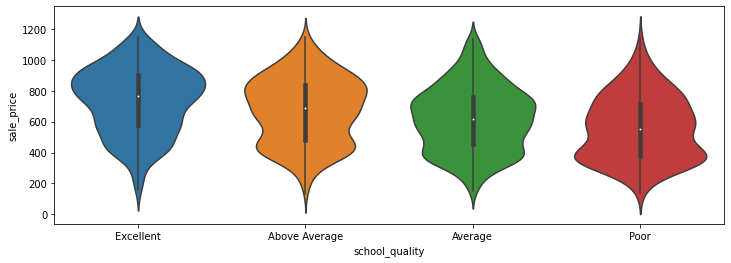

In [34]:
#Box Plot of School Quality
order=['Excellent', 'Above Average', 'Average', 'Poor']
temp = trimmed_df.copy()
plt.figure(figsize=(12,4))
sns.violinplot(x='school_quality', y='sale_price', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [35]:
#Create a dataset with just unique houses
drop_features = ['property_type', 'url', 'year', 'cpi', 'natural_disasters', 'zoning', 'geometry', 'date']
houses = trimmed_df.sort_values(by='sold_date', ascending=False).reset_index(drop=True)
print(f'Number of observations before removing duplicate houses {houses.shape[0]}')
houses = houses.drop_duplicates(subset='parcel_number')
houses.drop(drop_features, axis=1, inplace=True)
houses.rename(columns={'sold_date': 'date'}, inplace=True)
houses['sale_price'] = houses['sale_price']**2
houses['parcel_number'] = houses['parcel_number'].astype('O')
houses[['parcel_number', 'age', 'bedrooms', 'bathrooms', 'sex_offenders', 'enviornmental_hazards', 'year_built']] = houses[['parcel_number', 'age', 'bedrooms', 'bathrooms', 'sex_offenders', 'enviornmental_hazards', 'year_built']].astype(int)
print(f'Number of observations after removing duplicate houses {houses.shape[0]}')
houses.to_csv('Data/houses.csv', index=False)

Number of observations before removing duplicate houses 1855
Number of observations after removing duplicate houses 785


In [94]:
#Lets remove the features that won't be needed for the model
drop_features = ['address','year_built', 'parcel_number','date', 'sold_date', 'property_type', 'url', 'year', 'cpi', 'natural_disasters', 'zoning', 'geometry']
final_df = trimmed_df.drop(drop_features, axis=1)
final_df.to_csv('Data/house_data_details_eda.csv', index=False)

### Create/Update a sql database for the application

In [150]:
df_order = ['parcel_number', 'address', 'latitude', 'longitude', 'home_size', 'lot_size', 'year_built', 'age', 'sex_offenders', 'crime_index', 'enviornmental_hazards', 'school_quality', 'bedrooms', 'bathrooms', 'neighborhood', 'sale_price', 'sale_price_cpi', 'date']
houses = houses[df_order]

In [74]:
db = mysql.connector.connect(
    
    host = 'Samuels-MacBook-Air.local',
    user = 'root',
    passwd = details.db_password,
    database = 'realestate_avm'
)

mycursor = db.cursor()

In [153]:
#mycursor.execute('CREATE TABLE Homes (ParcelNumber VARCHAR(20) PRIMARY KEY, Address VARCHAR(50), Latitude DECIMAL(8,5), Longitude DECIMAL(8,5), HomeSize FLOAT UNSIGNED, LotSize FLOAT UNSIGNED, YearBuilt smallint UNSIGNED, Age smallint, SexOffenders tinyint UNSIGNED, CrimeIndex VARCHAR(15), EnviornmentalHazards tinyint UNSIGNED, SchoolQuality VARCHAR(15), Bedrooms tinyint UNSIGNED, Bathrooms tinyint UNSIGNED, Neighborhood VARCHAR(50), SalePrice FLOAT UNSIGNED, SalePriceTransformed FLOAT UNSIGNED, Date DATE)')

for index, row in houses.iterrows():
    mycursor.execute('INSERT INTO Homes(ParcelNumber, Address, Latitude, Longitude, HomeSize, LotSize, YearBuilt, Age, SexOffenders, CrimeIndex, EnviornmentalHazards, SchoolQuality, Bedrooms, Bathrooms, Neighborhood, SalePrice, SalePriceTransformed, Date) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s, %s)', tuple(row))
db.commit()

mycursor.close()
db.close()